<a href="https://colab.research.google.com/github/Garric59/DZ_BigData_dash_python/blob/dash/%22hw1_boosting_and_explanation_FullHD%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

## Gradient boosting on temporal data and feature importances

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.

* [Catboost](https://github.com/catboost/catboost) by Yandex. Novel framework by Yandex company tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

__Please, use [`shap`](https://github.com/slundberg/shap) and interpret the generated plots (with a brief summary).__

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

Здесь мы будем работать с широко известным набором данных Human Actividy Recognition (HAR). Данные доступны в репозитории UCI .

Доступны как необработанные, так и предварительно обработанные наборы данных. На этот раз мы воспользуемся препроцессором.

Сегодня мы будем работать с LightGBM от Microsoft. В наши дни это один из самых популярных фреймворков, который показывает отличное качество и производительность.

Есть и другие отличные фреймворки (перечисленные ниже). Однако мы будем придерживаться LightGBMэтой задачи.

Catboost от Яндекс. Новый фреймворк от компании Яндекс настроен на работу с категориальными функциями.
xgboost пользователя dlmc. Самый известный фреймворк, ставший очень популярным на kaggle.
За вас сделана простая предварительная обработка.

Ваша конечная цель - ознакомиться с одной из вышеперечисленных структур и достичь точности не менее 90% на тестовом наборе данных, а также попытаться получить полезную информацию о функциях, на которые модель обращала внимание.

Пожалуйста, используйте shapи интерпретируйте сгенерированные графики (с кратким изложением).

Несмотря на то, что основным языком этой записной книжки является английский, не стесняйтесь писать свои мысли на русском.

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [1]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [4]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [5]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [6]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [7]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

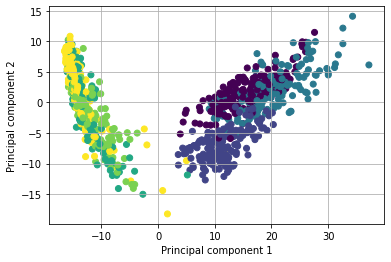

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

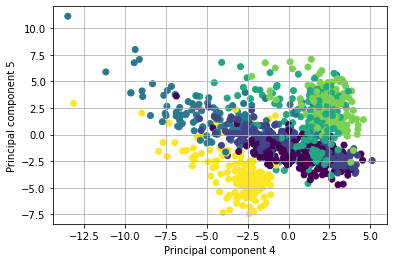

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

Несмотря на то, что оптимальные параметры (например, для xgboost) можно найти в Интернете, мы все же хотим, чтобы вы приблизили их самостоятельно. В этой части просто проверьте несколько (3-5) наборов гиперпараметров вручную.

In [12]:
# YOUR CODE HERE
!pip install lightgbm --upgrade
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgbm

import warnings
warnings.filterwarnings("ignore")

print("Версия LightGBM      : ", lgbm.__version__)
# Example: https://rpubs.com/burakh/har_xgb
from sklearn.model_selection import train_test_split
X, y = X_train_pca, y_train
X_train_train_pca, X_train_val_pca, y_train_train, y_train_val = train_test_split(X, y,
                                                    train_size=0.65, 
                                                    random_state=42,
                                                    stratify=y)

Версия LightGBM      :  3.3.1


In [13]:
#lgb_train = lgbm.Dataset(X_train_train_pca, label = y_train_train)
#lgb_eval = lgbm.Dataset(X_train_val_pca, label = y_train_val)

In [14]:
int(np.unique(y_train_train).size)

6

In [15]:
#validation_metrics = {}
param = {
    'objective':'multiclass',
    'num_class':int(np.unique(y_train_train).size),
    'metric':'multi_error'
}
lgb = lgbm.LGBMClassifier(**param)
lgb.fit(X=X_train_train_pca, y=y_train_train, eval_set=(X_train_val_pca, y_train_val))
validation_metrics=lgb.evals_result_

[1]	valid_0's multi_error: 0.176768
[2]	valid_0's multi_error: 0.130148
[3]	valid_0's multi_error: 0.113054
[4]	valid_0's multi_error: 0.103341
[5]	valid_0's multi_error: 0.0982906
[6]	valid_0's multi_error: 0.0928516
[7]	valid_0's multi_error: 0.0889666
[8]	valid_0's multi_error: 0.0846931
[9]	valid_0's multi_error: 0.0850816
[10]	valid_0's multi_error: 0.0823621
[11]	valid_0's multi_error: 0.0788656
[12]	valid_0's multi_error: 0.0796426
[13]	valid_0's multi_error: 0.0749806
[14]	valid_0's multi_error: 0.0718726
[15]	valid_0's multi_error: 0.0695416
[16]	valid_0's multi_error: 0.0687646
[17]	valid_0's multi_error: 0.0664336
[18]	valid_0's multi_error: 0.0648796
[19]	valid_0's multi_error: 0.0648796
[20]	valid_0's multi_error: 0.0644911
[21]	valid_0's multi_error: 0.0629371
[22]	valid_0's multi_error: 0.0629371
[23]	valid_0's multi_error: 0.0602176
[24]	valid_0's multi_error: 0.0606061
[25]	valid_0's multi_error: 0.0586636
[26]	valid_0's multi_error: 0.0594406
[27]	valid_0's multi_erro

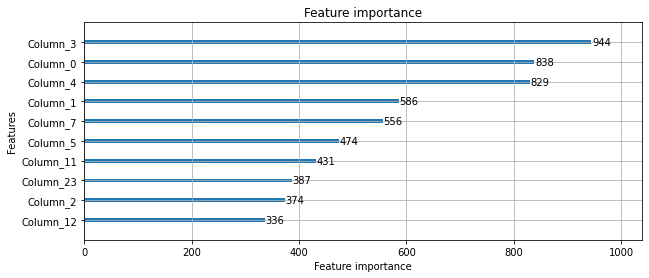

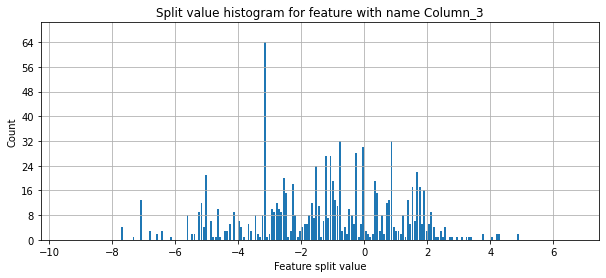

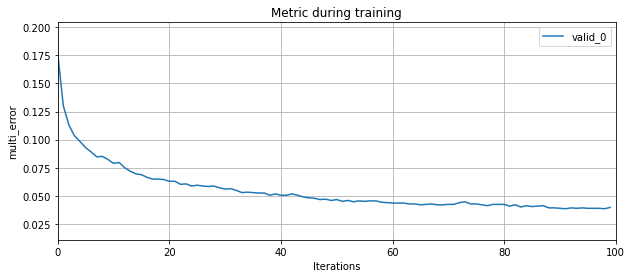

In [16]:
lgbm.plot_importance(lgb, figsize = (10,4),max_num_features=10)
lgbm.plot_split_value_histogram(lgb, feature = 'Column_3', figsize = (10,4))
lgbm.plot_metric(validation_metrics, metric='multi_error', figsize = (10,4))

In [17]:
prediction = np.rint(lgb.predict(X_train_val_pca, num_iteration=lgb.best_iteration_))
print("accuracy", accuracy_score(y_train_val, prediction))

accuracy 0.9603729603729604


model = lgbm.LGBMClassifier()
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data,
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=1,
        scoring=scoring_fit,
        verbose=100
    )
    fitted_model = gs.fit(X_train_data, y_train_data)

    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)

    return fitted_model, pred

param_grid = {
    'boosting_type':['gbdt'],
    #'learning_rate': [0.5, 0.1, 0.01], #скорости обучения
    'objective':['multiclass'],
    'num_class':[int(np.unique(y_train_train).size)],
    'n_estimators': [50, 100, 200], #Количество деревьев
    #'colsample_bytree': [0.6, 0.7, 0.8], #Соотношение подвыборки столбцов при построении каждого дерева
    'max_depth': [15, 20, 25], #Максимальная глубина дерева
    'num_leaves': [50, 100, 200], #Максимальное количество листьев дерева
    #'reg_alpha': [1.1, 1.2, 1.3], #регуляризации L1 по весам
    #'reg_lambda': [1.1, 1.2, 1.3], #регуляризации L2 по весам
    #'min_split_gain': [0, 0.2, 0.3, 0.4], #Минимальное снижение потерь
    #'min_child_samples':[10, 20, 30], #Минимальное количество данных, необходимых в дочернем (листе).
    #'subsample': [0.7, 0.8, 0.9], #Отношение подвыборки
    'metric':['multi_error', 'multi_logloss'],
    #'subsample_freq': [20, 21, 23], #Частота подвыборки
    'random_state':[42],
    #'importance_type':['split', 'gain']
}

model, pred = algorithm_pipeline(X_train_train_pca, X_train_val_pca, y_train_train, y_train_val, model,
                                 param_grid, cv=5, scoring_fit='accuracy')


best_model = model.best_score_
print("\nBest Accuracy: %f"%model.best_score_)
best_params = model.best_params_
print(model.best_params_)

lgb1 = lgbm.LGBMClassifier(**best_params)
lgb1.fit(X=X_train_train_pca, y=y_train_train, eval_set=(X_train_val_pca, y_train_val))
validation_metrics_2=lgb1.evals_result_

prediction = np.rint(lgb1.predict(X_train_val_pca, num_iteration=lgb1.best_iteration_))
print("accuracy", accuracy_score(y_train_val, prediction))

lgbm.plot_importance(lgb1, figsize = (10,4),max_num_features=10)
lgbm.plot_split_value_histogram(lgb1, feature = 'Column_3', figsize = (10,4))
lgbm.plot_metric(validation_metrics_2, metric='multi_error', figsize = (10,4))

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [18]:
# YOUR CODE HERE
!pip install optuna
import optuna
def step(trial):
    param = {'boosting_type':'gbdt',
             'learning_rate': trial.suggest_float('learning_rate',0.001, 1, log=True), #скорости обучения
             'objective':'multiclass',
             'num_class':[int(np.unique(y_train_train).size)],
             'n_estimators': trial.suggest_int('n_estimators',50, 200, log=True), #Количество деревьев
             'colsample_bytree': trial.suggest_float('colsample_bytree',0.5, 0.85, log=True), #Соотношение подвыборки столбцов при построении каждого дерева
             'max_depth': trial.suggest_int('max_depth', 15, 50, log=True), #Максимальная глубина дерева
             'num_leaves': trial.suggest_int('num_leaves', 50, 200,log=True), #Максимальное количество листьев дерева
             'lambda_l1':trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
             'lambda_l2':trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
             'min_split_gain': trial.suggest_float('min_split_gain', 0.5, 1.5, log=True), #Минимальное снижение потерь
             "min_child_samples":trial.suggest_int("min_child_samples", 5, 100), #Минимальное количество данных, необходимых в дочернем (листе).
             'subsample':trial.suggest_int('subsample', 1, 3, log=True), #Отношение подвыборки
             'metric': 'multi_error',
             'subsample_freq':trial.suggest_int('subsample_freq', 20, 30, log=True), #Частота подвыборки
             "feature_fraction":trial.suggest_float("feature_fraction", 0.4, 1.0),
             "bagging_fraction":trial.suggest_float("bagging_fraction", 0.4, 1.0),
             "bagging_freq":trial.suggest_int("bagging_freq", 1, 7),
             "verbose":-1
    }
    lgb_optimal = lgbm.LGBMClassifier(**param)
    lgb_optimal.fit(X_train_train_pca, y_train_train)
    prediction = np.rint(lgb_optimal.predict(X_train_val_pca, num_iteration=lgb_optimal.best_iteration_))
    accuracy = accuracy_score(y_train_val, prediction)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(step, n_trials=300, show_progress_bar=True)
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

[I 2021-11-30 09:00:36,743] A new study created in memory with name: no-name-5df2d962-5c11-4ac1-874d-5ff280c586de


  0%|          | 0/300 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.008603744024396431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008603744024396431
[LightGBM] [Warning] bagging_fraction is set=0.7478179684162467, subsample=1 will be ignored. Current value: bagging_fraction=0.7478179684162467
[LightGBM] [Warning] feature_fraction is set=0.9527346884743461, colsample_bytree=0.5012289870290424 will be ignored. Current value: feature_fraction=0.9527346884743461
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=29 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.016673863318945412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016673863318945412
[I 2021-11-30 09:00:39,111] Trial 0 finished with value: 0.9607614607614607 and parameters: {'learning_rate': 0.18159493549073238, 'n_estimators': 80, 'colsample_bytree': 0.5012289870290424, 'max_depth': 50, 'num_leaves': 51, 'lambda_l1': 0.008603744024396431, 'lambda_l2': 0.016673863318945412, 'min_s

In [19]:
print("best_params:", study.best_params)
best_param_optimal = study.best_params
print("Accuracy = %f" % (study.best_value*100))

best_params: {'learning_rate': 0.08966094536764291, 'n_estimators': 176, 'colsample_bytree': 0.542988293181697, 'max_depth': 30, 'num_leaves': 187, 'lambda_l1': 2.0856696907302502e-07, 'lambda_l2': 0.0007775988508272189, 'min_split_gain': 0.6211114454614451, 'min_child_samples': 86, 'subsample': 1, 'subsample_freq': 22, 'feature_fraction': 0.475859822960623, 'bagging_fraction': 0.6006869098236299, 'bagging_freq': 7}
Accuracy = 97.319347


lgb_final = lgbm.LGBMClassifier(**study.best_params)
lgb_final.fit(X_train, y_train)
predictFinal = np.rint(lgb_final.predict(X_test))
accuracy = accuracy_score(y_test, predictFinal)
print("Accuracy = %f" % (accuracy*100))

### Conclusion

Please, write down your thoughts on the experiment results:

...

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [20]:
lgb_final = lgbm.LGBMClassifier(**study.best_params) 
lgb_final.fit(X_train_train_pca, y_train_train) 
predictFinal = np.rint(lgb_final.predict(X_train_val_pca)) 
accuracy = accuracy_score(y_train_val, predictFinal) 
print("Accuracy = %f" % (accuracy*100))

[LightGBM] [Warning] lambda_l1 is set=2.0856696907302502e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0856696907302502e-07
[LightGBM] [Warning] bagging_fraction is set=0.6006869098236299, subsample=1 will be ignored. Current value: bagging_fraction=0.6006869098236299
[LightGBM] [Warning] feature_fraction is set=0.475859822960623, colsample_bytree=0.542988293181697 will be ignored. Current value: feature_fraction=0.475859822960623
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=22 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0007775988508272189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007775988508272189
Accuracy = 97.319347


In [21]:
!pip install shap
import shap

In [31]:
model = lgb_final.fit(X_train_train_pca, y_train_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_train_pca)

In [39]:
activity_labels.values()

dict_values(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])

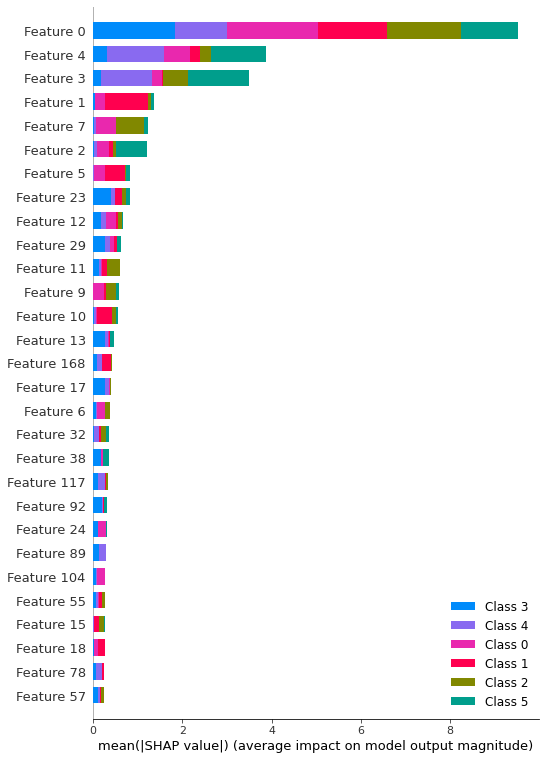

In [75]:
shap.summary_plot(shap_values, X_train_train_pca, max_display=int(179/6))

### Conclusion

Your thoughts about the plots and model behaviour:

...